<a href="https://colab.research.google.com/github/krglkvrmn/IB_Music_project/blob/master/ANN_genre_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music classification with ANN

In [1]:
import os
import random
import sys
import time
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# Setup
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
%matplotlib inline
plt.style.use('fivethirtyeight')

def multilabel_accuracy(preds: torch.Tensor, y_test: torch.Tensor) -> float:
    preds = preds.cpu().numpy()
    y_test = y_test.cpu().numpy()
    score = 0
    masked = preds * y_test
    for row_p, row_t, row_m in zip(preds, y_test, masked):
        top = set(sorted(row_p, reverse=True)[:int(row_t.sum().item())])
        row_preds = set(row_m[row_m != 0])
        score += len(row_preds & top)
    return round(score / sum(y_test.ravel()), 4)

!nvidia-smi

Fri Apr 23 21:16:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data loading

In [ ]:
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
datadir =  "/content/drive/MyDrive/music_classification/data/"
fma_datadir = "/content/drive/MyDrive/music_classification/data/fma"
mel_spec_datadir = "/content/drive/MyDrive/music_classification/data/fma/spectrograms/mel"
ib_dataset_dir = "/content/drive/MyDrive/music_classification/data/fma/data/"
sys.path.append(os.path.join(datadir, "fma", "models"))
os.listdir(os.path.join(mel_spec_datadir))

['mel_spec_4096_2048_20.npy', 'mel_spec_2048_512_90.npy']

### Load genres from pre-processed FMA metadate file

In [ ]:
data = pd.read_csv(os.path.join(fma_datadir, "tracks_genre_small.csv"))
blacklist = set(["fma_small/098/098565.mp3",
                 "fma_small/098/098567.mp3",
                 "fma_small/098/098569.mp3",
                 "fma_small/099/099134.mp3",
                 "fma_small/108/108925.mp3",
                 "fma_small/133/133297.mp3"])
data = data.query("filepath not in @blacklist")
encoder = LabelEncoder()

### Load MFCC and Log-mel-spectrograms of small FMA dataset

In [ ]:
X_mfcc = np.load(os.path.join(fma_datadir, "mfcc", "mfcc_13.npy"))
X_spec = np.load(os.path.join(mel_spec_datadir, "mel_spec_2048_512_90.npy"))

In [ ]:
# Reshape MFCC array so we can concatenate it with spectrograms
X = np.concatenate((X_mfcc.reshape((X_mfcc.shape[0], X_mfcc.shape[2], X_mfcc.shape[1])), X_spec), axis=1)  

In [ ]:
# y = encoder.fit_transform(data.genre_top)                   # Test values for 8 class single-label classification
y = np.load(os.path.join(fma_datadir, "genre_dummies.npy"))   # Test values for 114 class multi-label classification

In [ ]:
# Delete variables to avoid RAM overflow
del X_mfcc, X_spec

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Delete variables to avoid RAM overflow
del X

In [ ]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

In [ ]:
X_train.shape

torch.Size([6395, 129, 1271])

In [ ]:
device = torch.device("cuda:0")

## ANN architectures

In [ ]:
class HybrydMLNet(torch.nn.Module):
    """Predicts 114 genres. Takes (batch_size, 1, 129, 1271) as input"""
    def __init__(self):
        super(HybrydMLNet, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(7, 11), padding=(3, 5), stride=(3, 5))
        self.act1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm2d(num_features=32)
        self.do1 = torch.nn.Dropout2d(0.05)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=(2, 3))
        
        self.conv1ad = torch.nn.Conv2d(in_channels=32, out_channels=128, kernel_size=(5, 7), padding=(2, 5), stride=(3, 3))
        self.act1ad = torch.nn.ELU()
        self.bn2 = torch.nn.BatchNorm2d(num_features=128)
        self.do2 = torch.nn.Dropout2d(0.05)
        self.pool1ad = torch.nn.AvgPool2d(kernel_size=(1, 3))
        
        self.conv2 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.act2 = torch.nn.SELU()
        self.bn3 = torch.nn.BatchNorm2d(num_features=256)
        self.do3 = torch.nn.Dropout2d(0.05)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=(1, 2))
        
        self.conv2ad = torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(5, 3), padding=(2, 1))
        self.act2ad = torch.nn.ReLU()
        self.bn4 = torch.nn.BatchNorm2d(num_features=512)
        self.do4 = torch.nn.Dropout2d(0.05)
        self.pool2ad = torch.nn.AvgPool2d(kernel_size=5, stride=3, padding=2)
        
        self.fc1 = torch.nn.Linear(3072, 1024)
        self.fc1_act = torch.nn.ELU()
        
        self.fc2 = torch.nn.Linear(1024, 512)
        self.fc2_act = torch.nn.ReLU()
        
        self.fc3 = torch.nn.Linear(512, 256)
        self.fc3_act = torch.nn.Tanh()

        self.fc4 = torch.nn.Linear(256, 114)
    
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.bn1(x)
        x = self.do1(x)
        x = self.pool1(x)
        
        x = self.conv1ad(x)
        x = self.act1ad(x)
        x = self.bn2(x)
        x = self.do2(x)
        x = self.pool1ad(x)
        
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.bn3(x)
        x = self.do3(x)
        x = self.pool2(x)
        
        x = self.conv2ad(x)
        x = self.act2ad(x)
        x = self.bn4(x)
        x = self.do4(x)
        x = self.pool2ad(x)
        
        
        
        x = x.view(x.size(0), x.size(1)*x.size(2)*x.size(3))

        x = self.fc1(x)
        x = self.fc1_act(x)

        x = self.fc2(x)
        x = self.fc2_act(x)
        
        x = self.fc3(x)
        x = self.fc3_act(x)

        x = self.fc4(x)

        return x


class HybrydNet(torch.nn.Module):
    """Predicts 8 genres. Takes (batch_size, 1, 129, 1271) as input"""
    def __init__(self):
        super(HybrydNet, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(7, 11), padding=(3, 5), stride=(3, 5))
        self.act1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm2d(num_features=32)
        self.do1 = torch.nn.Dropout2d(0.05)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=(2, 3))
        
        self.conv1ad = torch.nn.Conv2d(in_channels=32, out_channels=128, kernel_size=(5, 7), padding=(2, 5), stride=(3, 3))
        self.act1ad = torch.nn.ELU()
        self.bn2 = torch.nn.BatchNorm2d(num_features=128)
        self.do2 = torch.nn.Dropout2d(0.05)
        self.pool1ad = torch.nn.AvgPool2d(kernel_size=(1, 3))
        
        self.conv2 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.act2 = torch.nn.SELU()
        self.bn3 = torch.nn.BatchNorm2d(num_features=256)
        self.do3 = torch.nn.Dropout2d(0.05)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=(1, 2))
        
        self.conv2ad = torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(5, 3), padding=(2, 1))
        self.act2ad = torch.nn.ReLU()
        self.bn4 = torch.nn.BatchNorm2d(num_features=512)
        self.do4 = torch.nn.Dropout2d(0.05)
        self.pool2ad = torch.nn.AvgPool2d(kernel_size=5, stride=3, padding=2)
        
        self.fc1 = torch.nn.Linear(3072, 1024)
        self.fc1_act = torch.nn.ELU()
        
        self.fc2 = torch.nn.Linear(1024, 256)
        self.fc2_act = torch.nn.ReLU()
        
        self.fc3 = torch.nn.Linear(256, 64)
        self.fc3_act = torch.nn.Tanh()

        self.fc4 = torch.nn.Linear(64, 8)
    
    def forward(self, x):
        x = x.unsqueeze(1)

        x = self.conv1(x)
        x = self.act1(x)
        x = self.bn1(x)
        x = self.do1(x)
        x = self.pool1(x)
        
        x = self.conv1ad(x)
        x = self.act1ad(x)
        x = self.bn2(x)
        x = self.do2(x)
        x = self.pool1ad(x)
        
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.bn3(x)
        x = self.do3(x)
        x = self.pool2(x)
        
        x = self.conv2ad(x)
        x = self.act2ad(x)
        x = self.bn4(x)
        x = self.do4(x)
        x = self.pool2ad(x)
        
        
        
        x = x.view(x.size(0), x.size(1)*x.size(2)*x.size(3))

        x = self.fc1(x)
        x = self.fc1_act(x)

        x = self.fc2(x)
        x = self.fc2_act(x)
        
        x = self.fc3(x)
        x = self.fc3_act(x)

        x = self.fc4(x)

        return x

In [ ]:
net = HybrydMLNet()      # Create model HybrydNet or HybrydMLNet
net.to(device)
net.train()              

lr = 4e-4
epochs = 100

# Choose loss function: CrossEntropyLoss for HybrydNet and BCEWithLogitsLoss for HybrydMLNet
# loss = torch.nn.CrossEntropyLoss()                 
loss = torch.nn.BCEWithLogitsLoss()

# Select optimizer
#optimizer = torch.optim.SGD(net.parameters(), lr=lr)
#optimizer = torch.optim.Adam(net.parameters(), lr=lr)
optimizer = torch.optim.RMSprop(net.parameters(), lr=lr)
#optimizer = torch.optim.Rprop(lenet5.parameters(), lr=lr)

In [ ]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = net.forward(X_batch)
        
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
    
    with torch.no_grad():
        test_preds = net.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test).data.cpu()) 
        # accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()     # For HybrydNet
        accuracy = multilabel_accuracy(test_preds, y_test)                              # For HybrydMLNet
        test_accuracy_history.append(accuracy)
        print(accuracy, epoch)

0.1169 0
0.217 1
0.2433 2
0.2577 3
0.2831 4
0.282 5
0.2548 6
0.2681 7
0.2747 8
0.3004 9
0.3152 10
0.3157 11
0.3273 12
0.3302 13
0.3276 14
0.331 15
0.3221 16
0.3498 17
0.3449 18
0.3449 19
0.3518 20
0.3605 21
0.3619 22
0.357 23
0.3697 24
0.3631 25
0.3665 26
0.3749 27
0.3864 28
0.3784 29
0.3887 30
0.3835 31
0.3833 32
0.3752 33
0.4026 34
0.3939 35
0.4038 36
0.3965 37
0.4006 38
0.3934 39
0.3997 40
0.4124 41
0.4 42
0.4098 43
0.4115 44
0.4271 45
0.4193 46
0.4225 47
0.4121 48
0.4188 49
0.4196 50
0.4367 51
0.4274 52
0.4343 53
0.4289 54
0.432 55
0.4358 56
0.4286 57


In [ ]:
# Save model
torch.save(net.state_dict(), os.path.join(datadir, "fma", "models", "HybrydMlNet114_043.pt"))

Text(0, 0.5, 'Loss')

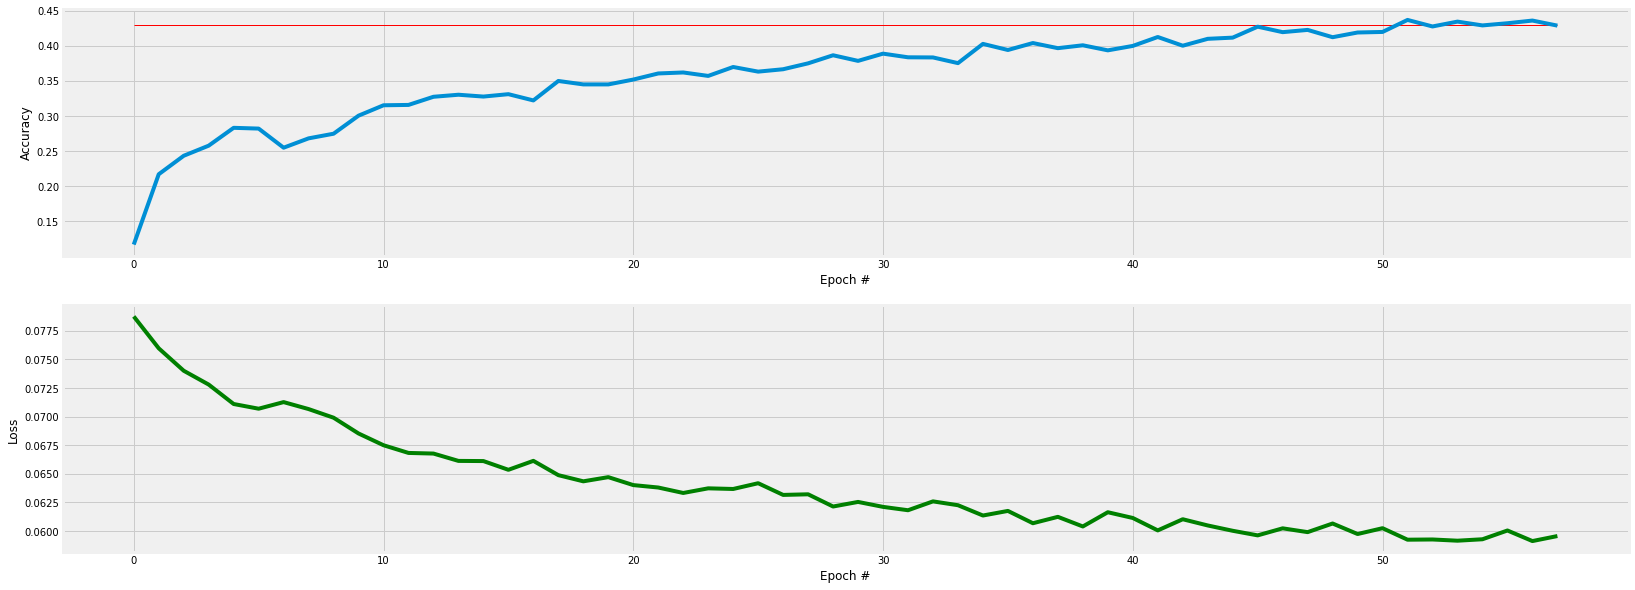

In [ ]:
plt.rc("figure", figsize=(25, 10))

fig, ax = plt.subplots(2, 1)
ax[0].plot(test_accuracy_history)
ax[0].hlines(0.43,  0, 57, color="r", lw=1)
ax[0].set_xlabel("Epoch #")
ax[0].set_ylabel("Accuracy")

ax[1].plot(test_loss_history, color="g")
ax[1].set_xlabel("Epoch #")
ax[1].set_ylabel("Loss")

In [ ]:
from google.colab import files
files.upload()

In [ ]:
# Manual prediction test
# 650475 is hardcoded parameter for number of samples composing 29.5 seconds with sr=20050 
import librosa as lb

net.eval()

FRAME_SIZE = 2048
HOP_LENGTH = 512

ml_labels = ['Avant-Garde', 'International', 'Sound Art', 'Novelty', 'Turkish', 'Pop', 'New Age', 'Rock', 'Romany (Gypsy)', 'Electronic', 'Sound Effects', 'Folk', 'Soundtrack', 'Hip-Hop', 'Audio Collage', 'Punk', 'Post-Rock', 'Lo-Fi', 'Compilation', 'Rap', 'Field Recordings', 'Metal', 'Noise', 'Psych-Folk', 'Trip-Hop', 'Breakbeat', 'Krautrock', 'Tango', 'Experimental', 'Dance', 'Electroacoustic', 'Chip Music', 'Ambient Electronic', 'Hip-Hop Beats', 'Loud-Rock', 'Latin America', 'Drone', 'Salsa', 'Free-Folk', 'Noise-Rock', 'Psych-Rock', 'Goth', 'Electro-Punk', 'Indie-Rock', 'Abstract Hip-Hop', 'Industrial', 'No Wave', 'Experimental Pop', 'French', 'Reggae - Dub', 'Drum & Bass', 'Afrobeat', 'Nerdcore', 'Garage', 'Indian', 'New Wave', 'Post-Punk', 'Reggae - Dancehall', 'Sludge', 'African', 'Freak-Folk', 'Progressive', 'Alternative Hip-Hop', 'Death-Metal', 'Middle East', 'Singer-Songwriter', 'Shoegaze', 'Kid-Friendly', 'Synth Pop', 'Spanish', 'Ambient', 'Hardcore', 'Thrash', 'Power-Pop', 'Space-Rock', 'Polka', 'Balkan', 'Unclassifiable', 'Europe', 'Chill-out', 'Bigbeat', 'Surf', 'Black-Metal', 'Christmas', 'Brazilian', 'Asia-Far East', 'South Indian Traditional', 'Celtic', 'British Folk', 'Techno', 'House', 'Glitch', 'Rock Opera', 'Breakcore - Hard', 'Minimal Electronic', 'Sound Poetry', 'Grindcore', 'Jungle', 'Minimalism', 'Instrumental', 'Dubstep', 'North African', 'Sound Collage', 'Klezmer', 'Flamenco', 'Skweee', 'IDM', 'Downtempo', 'Chiptune', 'Cumbia', 'Musique Concrete', 'Latin', 'Improv', 'Holiday']

filepath = os.path.join(ib_dataset_dir, "RHODONITE_AND_GRIEF-La_Dispute.mp3")
signal, sr = lb.load(filepath)
for i in range(signal.size // 650475):
    mel_spec = lb.feature.melspectrogram(signal[650475*i:650475*(i+1)], sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH, n_mels=90)
    log_mel_spec = lb.power_to_db(mel_spec)

    mfcc = lb.feature.mfcc(signal[650475*i:650475*(i+1)], n_mfcc=13)
    mfcc2 = lb.feature.delta(mfcc)
    mfcc3 = lb.feature.delta(mfcc, order=2)
    mfcc = np.concatenate((mfcc, mfcc2, mfcc3))

    X = torch.tensor(np.concatenate((mfcc, log_mel_spec))).unsqueeze(0).to(device)
    preds = list(zip(torch.nn.Softmax()(net.forward(X))[0].data, ml_labels))
    preds.sort(reverse=True)
    print(preds[0][1], "-", preds[1][1], "-", preds[2][1], f"({preds[0][0]:.3f}:{preds[1][0]:.3f}:{preds[2][0]:.3f})")

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Rock - Pop - Instrumental (0.226:0.205:0.065)
Rock - Pop - Indie-Rock (0.311:0.171:0.069)
Rock - Pop - Instrumental (0.202:0.197:0.062)
Experimental - Folk - Instrumental (0.198:0.110:0.109)
Rock - Surf - Punk (0.461:0.074:0.073)
Rock - Pop - Indie-Rock (0.330:0.151:0.068)
Rock - Pop - Indie-Rock (0.270:0.201:0.067)
